In [1]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import pandas as pd
def correlation_center_finder(grid1, grid2):
    def cycle_matrix(matrix, row_shift, col_shift):
        row_shift %= matrix.shape[0]
        col_shift %= matrix.shape[1]
        return np.roll(np.roll(matrix, row_shift, axis=0), col_shift, axis=1)
    def compare_matrices_ssim(matrix1, matrix2):
        data_range = matrix1.max() - matrix1.min()
        return np.abs(ssim(matrix1, matrix2, data_range=data_range)) # Have |SSIM| it 
    def center_list(n):
        midpoint = n // 2
        return np.arange(-midpoint, n - midpoint)
    xs = center_list(grid1.shape[1])
    ys = center_list(grid1.shape[0])
    correlations = [
        (x, y, compare_matrices_ssim(grid1, cycle_matrix(grid2, y, x)))
        for x in xs for y in ys
    ]
    df = pd.DataFrame(correlations, columns=['Right', 'Up', 'Correlation'])
    best_shift = df.loc[df['Correlation'].idxmax()]
    return df, best_shift['Up'], best_shift['Right']
    
from shapely.geometry import Polygon
def calculate_centroid(xt, yt):
    if len(xt) == 0:
        return np.nan, np.nan
    polygon = Polygon(zip(xt, yt))
    centroid = polygon.centroid
    return centroid.x, centroid.y
    
def calculate_okubo_weis(uu, vv, dx, dy):
    WIDTH, LENGTH, SIGMAS = uu.shape
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(LOW):
    ocean_mask = np.where(np.isnan(LOW), np.zeros_like(LOW), 1)
    OW_mean = np.nansum(LOW) / np.sum(ocean_mask)
    OW_std = np.sqrt(np.nansum(ocean_mask * (LOW - OW_mean) ** 2) / np.sum(ocean_mask))
    return LOW / OW_std

def make_cartesian(lon, lat, theta0, phi0):
    lonr, latr = np.deg2rad(lon), np.deg2rad(lat)
    r_earth = 6371
    x = r_earth * np.cos(np.deg2rad(phi0)) * (lonr - np.deg2rad(theta0))
    y = r_earth * (latr - np.deg2rad(phi0))
    return x, y



## No Tilt

In [2]:
def calculate_eddy(WIDTH=500000, DEPTH_LAYERS=10, eta0=1, L=1e5, H=1200, a=1, b=1, rho0=1025, 
                                            f0=None, alpha_1=0.01, alpha_2=0.01, T0=20, dTdz=-0.01):
    """
    Calculate the 3D geostrophic velocity components U, V, density anomaly sigma, and temperature field for an ocean eddy.
    
    Parameters:
    - WIDTH: Horizontal extent of the grid (eddy scale) in meters.
    - DEPTH_LAYERS: Number of vertical layers (depth resolution).
    - eta0: Surface elevation perturbation.
    - L: Horizontal length scale of the eddy in meters.
    - H: Vertical depth scale of the eddy in meters.
    - a: Linear coefficient for stratification.
    - b: Exponential coefficient for density anomaly.
    - rho0: Reference density (kg/m^3).
    - f0: Coriolis parameter. If None, it will be calculated based on a latitude of -40 degrees.
    - alpha_1: Coefficient for x_c(z), affects the horizontal shift of the eddy center with depth in the x direction.
    - alpha_2: Coefficient for y_c(z), affects the horizontal shift of the eddy center with depth in the y direction.
    - T0: Surface temperature at z = 0 (degrees Celsius).
    - dTdz: Temperature gradient with depth (degrees Celsius per meter).
    
    Returns:
    - U: 3D matrix for the U (x-component) velocity field.
    - V: 3D matrix for the V (y-component) velocity field.
    - sigma: 3D matrix for the density anomaly.
    - T: 3D matrix for the temperature field.
    - CS: Speed magnitude.
    """
    
    # Constants
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-40))  # Coriolis parameter for latitude -40 degrees
    g = 9.81  # Gravitational acceleration (m/s^2)

    # Create 2D meshgrid for horizontal space (x, y) and depth (z)
    x = np.linspace(-WIDTH//2, WIDTH//2, 100)  # x-coordinates
    y = np.linspace(-WIDTH//2, WIDTH//2, 100)  # y-coordinates
    z = np.linspace(-H, 0, DEPTH_LAYERS)  # Depth levels from surface (0) to -H

    # Create 3D meshgrid
    x_3d, y_3d, z_3d = np.meshgrid(x, y, z, indexing='ij')

    # Define the functions f(|r - r_c(z)|) and g(z)
    def f_r_rc(r, L):
        return np.exp(-r**2 / L**2)

    def g_z(z, H):
        return np.exp(z / H)

    # Calculate the center position as a function of depth
    x_c = alpha_1 * z_3d
    y_c = alpha_2 * z_3d

    # Calculate radial distance r - r_c(z)
    r_c = np.sqrt((x_3d - x_c)**2 + (y_3d - y_c)**2)

    # Calculate density anomaly sigma with the modified equation
    sigma = rho0 - a * z_3d + b * f_r_rc(r_c, L) * g_z(z_3d, H)

    # Calculate 3D geostrophic velocity components for the eddy
    U = 2 * g * y_3d / (f0 * L**2) * (b * H / rho0 * (1 - np.exp(z_3d / H)) - eta0) * np.exp(-r_c**2 / L**2)
    V = -2 * g * x_3d / (f0 * L**2) * (b * H / rho0 * (1 - np.exp(z_3d / H)) - eta0) * np.exp(-r_c**2 / L**2)

    # Calculate speed magnitude
    CS = np.sqrt(U**2 + V**2)
    
    # Calculate temperature as a linear function of depth with horizontal variation
    # T0 is the surface temperature, dTdz is the rate of temperature decrease with depth
    T = T0 + dTdz * z_3d - 0.5 * f_r_rc(r_c, L)  # Horizontal variation based on distance from the eddy center
    TA = T - np.mean(T)

    U = np.flip(U, axis=2)
    V = np.flip(V, axis=2)
    sigma = np.flip(sigma, axis=2)
    TA = np.flip(TA, axis=2)
    CS  = np.flip(CS, axis=2)
    z = np.flip(z)
    
    return U, V, sigma, TA, CS, x/1000, y/1000, z


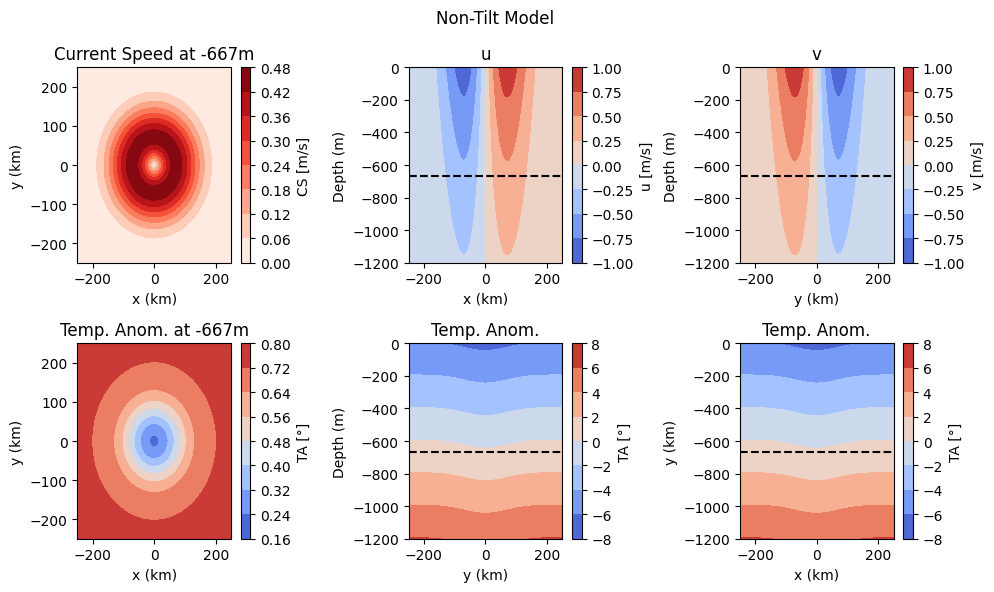

In [3]:
U, V, sigma, TA, CS, x, y, z = calculate_eddy()

DEPTH_LVL = 5
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

# Plot Current Speed
c1 = axs[0,0].contourf(x, y, CS[:,:,DEPTH_LVL].T, cmap='Reds')
fig.colorbar(c1, ax=axs[0,0], label='CS [m/s]')
axs[0,0].set_title('Current Speed at '+str(round(z[DEPTH_LVL]))+'m')
axs[0,0].set_xlabel('x (km)')
axs[0,0].set_ylabel('y (km)')

# Plot u velocity
contour_u = axs[0,1].contourf(x, z, U[U.shape[0]//2,:,:].T, cmap='coolwarm')
fig.colorbar(contour_u, ax=axs[0,1], label='u [m/s]')
axs[0,1].plot([x[0],x[-1]],[z[DEPTH_LVL],z[DEPTH_LVL]],'--',color='k')
axs[0,1].set_title('u')
axs[0,1].set_xlabel('x (km)')
axs[0,1].set_ylabel('Depth (m)')

# Plot v velocity
contour_v = axs[0,2].contourf(y, z, V[:,V.shape[1]//2,:].T, cmap='coolwarm')
fig.colorbar(contour_v, ax=axs[0,2], label='v [m/s]')
axs[0,2].plot([y[0],y[-1]],[z[DEPTH_LVL],z[DEPTH_LVL]],'--',color='k')
axs[0,2].set_title('v')
axs[0,2].set_xlabel('y (km)')
axs[0,2].set_ylabel('Depth (m)')

# Plot Temperature Anomaly (TA) for the current depth level
c2 = axs[1,0].contourf(x, y, TA[:,:,DEPTH_LVL].T, cmap='coolwarm')
fig.colorbar(c2, ax=axs[1,0], label='TA [°]')
axs[1,0].set_title('Temp. Anom. at '+str(round(z[DEPTH_LVL]))+'m')
axs[1,0].set_xlabel('x (km)')
axs[1,0].set_ylabel('y (km)')

# Plot Temperature Anomaly at x = middle slice
temp_x = axs[1,1].contourf(x, z, TA[TA.shape[0]//2,:,:].T, cmap='coolwarm')
fig.colorbar(temp_x, ax=axs[1,1], label='TA [°]')
axs[1,1].plot([x[0],x[-1]],[z[DEPTH_LVL],z[DEPTH_LVL]],'--',color='k')
axs[1,1].set_title('Temp. Anom.')
axs[1,1].set_xlabel('y (km)')
axs[1,1].set_ylabel('Depth (m)')

# Plot Temperature Anomaly at y = middle slice
temp_y = axs[1,2].contourf(y, z, TA[:,TA.shape[1]//2,:].T, cmap='coolwarm')
fig.colorbar(temp_y, ax=axs[1,2], label='TA [°]')
axs[1,2].plot([y[0],y[-1]],[z[DEPTH_LVL],z[DEPTH_LVL]],'--',color='k')
axs[1,2].set_title('Temp. Anom.')
axs[1,2].set_xlabel('x (km)')
axs[1,2].set_ylabel('y (km)')

fig.suptitle('Non-Tilt Model')

plt.tight_layout()
plt.show()


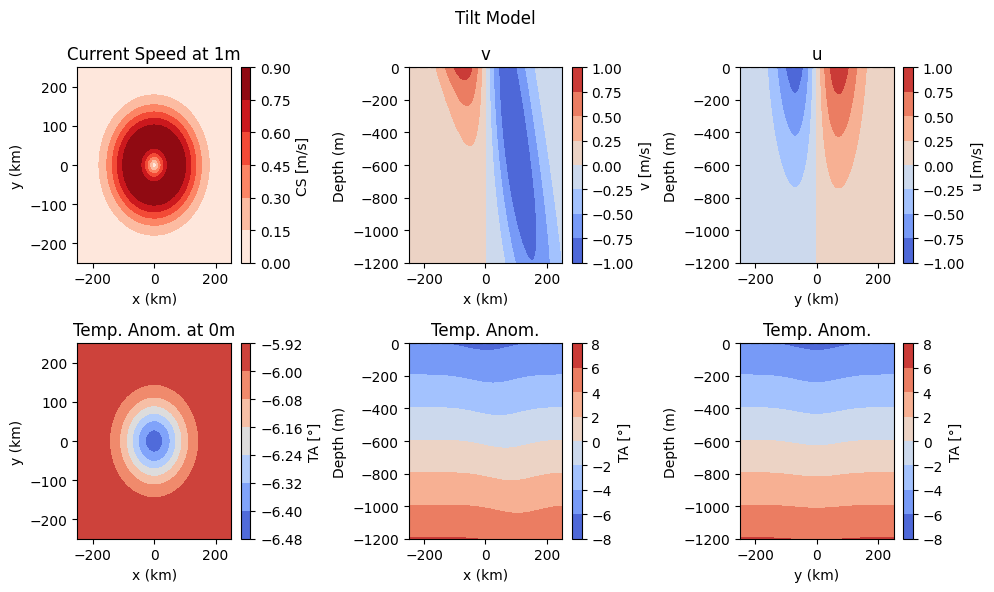

In [69]:
U_tilt, V_tilt, sigma_tilt, TA_tilt, CS_tilt, x_tilt, y_tilt, z_tilt = calculate_eddy(alpha_1=-100)

DEPTH_LVL = 0
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

# Plot Current Speed
c1 = axs[0,0].contourf(x_tilt, y_tilt, CS_tilt[:,:,DEPTH_LVL].T, cmap='Reds')
fig.colorbar(c1, ax=axs[0,0], label='CS [m/s]')
axs[0,0].set_title('Current Speed at '+str(round(z[DEPTH_LVL]))+'m')
axs[0,0].set_xlabel('x (km)')
axs[0,0].set_ylabel('y (km)')

# Plot v velocity
contour_v = axs[0,1].contourf(y_tilt, z_tilt, V_tilt[:,V_tilt.shape[1]//2,:].T, cmap='coolwarm')
fig.colorbar(contour_v, ax=axs[0,1], label='v [m/s]')
axs[0,1].plot([y_tilt[0],y_tilt[-1]],[z_tilt[DEPTH_LVL],z_tilt[DEPTH_LVL]],'--',color='k')
axs[0,1].set_title('v')
axs[0,1].set_xlabel('x (km)')
axs[0,1].set_ylabel('Depth (m)')

# Plot u velocity
contour_u = axs[0,2].contourf(x_tilt, z_tilt, U_tilt[U_tilt.shape[0]//2,:,:].T, cmap='coolwarm')
fig.colorbar(contour_u, ax=axs[0,2], label='u [m/s]')
axs[0,2].plot([x_tilt[0],x_tilt[-1]],[z_tilt[DEPTH_LVL],z_tilt[DEPTH_LVL]],'--',color='k')
axs[0,2].set_title('u')
axs[0,2].set_xlabel('y (km)')
axs[0,2].set_ylabel('Depth (m)')

# Plot Temperature Anomaly (TA) for the current depth level
c2 = axs[1,0].contourf(x_tilt, y_tilt, TA_tilt[:,:,DEPTH_LVL].T, cmap='coolwarm')
fig.colorbar(c2, ax=axs[1,0], label='TA [°]')
axs[1,0].set_title('Temp. Anom. at '+str(round(z_tilt[DEPTH_LVL]))+'m')
axs[1,0].set_xlabel('x (km)')
axs[1,0].set_ylabel('y (km)')

# Plot Temperature Anomaly at y = middle slice
temp_y = axs[1,1].contourf(y_tilt, z_tilt, TA_tilt[:,TA_tilt.shape[1]//2,:].T, cmap='coolwarm')
fig.colorbar(temp_y, ax=axs[1,1], label='TA [°]')
axs[1,1].plot([y_tilt[0],y_tilt[-1]],[z_tilt[DEPTH_LVL],z_tilt[DEPTH_LVL]],'--',color='k')
axs[1,1].set_title('Temp. Anom.')
axs[1,1].set_xlabel('x (km)')
axs[1,1].set_ylabel('Depth (m)')

# Plot Temperature Anomaly at x = middle slice
temp_x = axs[1,2].contourf(x_tilt, z_tilt, TA_tilt[TA_tilt.shape[0]//2,:,:].T, cmap='coolwarm')
fig.colorbar(temp_x, ax=axs[1,2], label='TA [°]')
axs[1,2].plot([x_tilt[0],x_tilt[-1]],[z_tilt[DEPTH_LVL],z_tilt[DEPTH_LVL]],'--',color='k')
axs[1,2].set_title('Temp. Anom.')
axs[1,2].set_xlabel('y (km)')
axs[1,2].set_ylabel('Depth (m)')

fig.suptitle('Tilt Model')

plt.tight_layout()
plt.show()


## OW Isosurface

In [5]:
def compute_flow_directions(u, v):
    nan_mask = np.isnan(u) | np.isnan(v)
    direction_matrix = np.full(u.shape, np.nan)
    valid_mask = ~nan_mask
    u_valid, v_valid = u[valid_mask], v[valid_mask]
    
    if u_valid.size > 0:
        angles_degrees = np.degrees(np.arctan2(v_valid, u_valid)) % 360
        direction_matrix_valid = np.zeros(u_valid.shape, dtype=int)
        direction_matrix_valid[(angles_degrees >= 0) & (angles_degrees < 90)] = 1
        direction_matrix_valid[(angles_degrees >= 90) & (angles_degrees < 180)] = 2
        direction_matrix_valid[(angles_degrees >= 180) & (angles_degrees < 270)] = 3
        direction_matrix_valid[(angles_degrees >= 270) & (angles_degrees < 360)] = 4
        direction_matrix[valid_mask] = direction_matrix_valid

    return direction_matrix

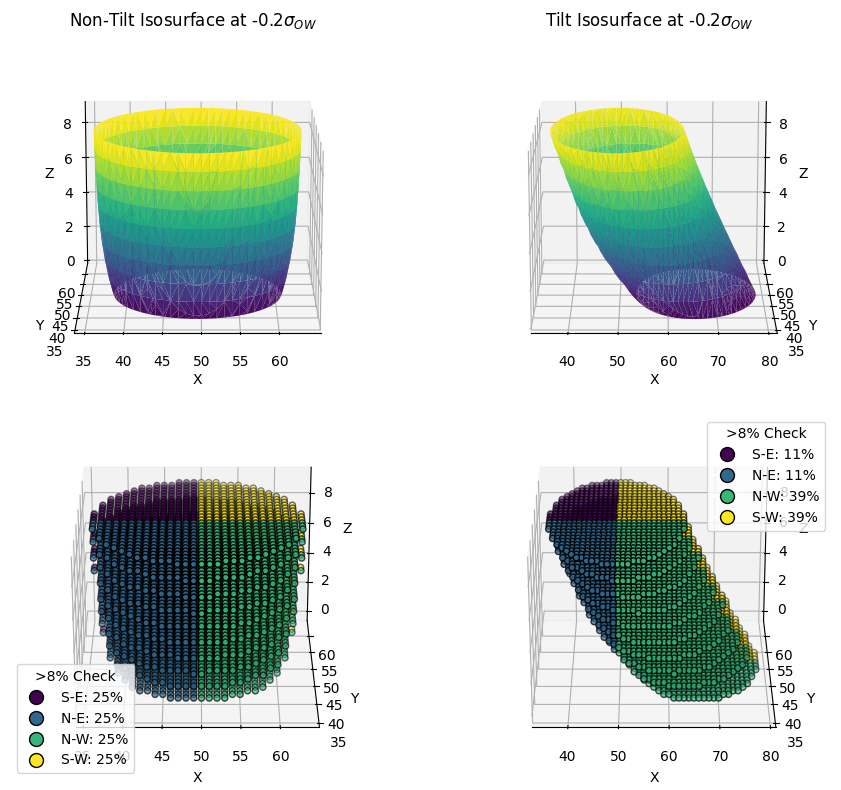

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize

OW_THRESH = -.2

ow = calculate_okubo_weis(U, V, x[1]-x[0], y[1]-y[0])
ow = normalize_matrix(ow)

ow_tilt = calculate_okubo_weis(U_tilt, V_tilt, x_tilt[1]-x_tilt[0], y_tilt[1]-y_tilt[0])
ow_tilt = normalize_matrix(ow_tilt)

fig = plt.figure(figsize=(10, 8))

# Non-Tilt Isosurface
ax1 = fig.add_subplot(221, projection='3d')
# X, Y, Z = np.meshgrid(x, y, z)
verts, faces, _, _ = measure.marching_cubes(np.flip(ow, axis=2), OW_THRESH)
ax1.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces, cmap='viridis', lw=1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(r'Non-Tilt Isosurface at -0.2$\sigma_{OW}$')
ax1.view_init(elev=15, azim=270)

# Tilt Isosurface
ax2 = fig.add_subplot(222, projection='3d')
verts_tilt, faces_tilt, _, _ = measure.marching_cubes(np.flip(ow_tilt, axis=2), OW_THRESH)
ax2.plot_trisurf(verts_tilt[:, 0], verts_tilt[:, 1], verts_tilt[:, 2], triangles=faces_tilt, cmap='viridis', lw=1)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title(r'Tilt Isosurface at -0.2$\sigma_{OW}$')
ax2.view_init(elev=15, azim=270)

# Non-Tilt Direction Grouping
ax3 = fig.add_subplot(223, projection='3d')
emask = ow < OW_THRESH
u_mask = np.where(emask, U, np.nan)
v_mask = np.where(emask, V, np.nan)
dmat = np.flip(compute_flow_directions(u_mask, v_mask), axis=2)
i, j, k = np.where(~np.isnan(dmat))
values = dmat[~np.isnan(dmat)]
norm = Normalize(vmin=np.min(values), vmax=np.max(values))
sc = ax3.scatter(i, j, k, c=values, edgecolor='k')
labels = ['S-E: '+str(round(np.sum(values==1)/len(values)*100))+'%',
          'N-E: '+str(round(np.sum(values==2)/len(values)*100))+'%',
          'N-W: '+str(round(np.sum(values==3)/len(values)*100))+'%',
          'S-W: '+str(round(np.sum(values==4)/len(values)*100))+'%']
unique_values = np.unique(values)
cmap = plt.colormaps['viridis']
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(i)),
           markeredgecolor='k', markersize=10, label=labels[idx]) 
    for idx, i in enumerate(unique_values)
]
ax3.legend(handles=legend_elements, title=">8% Check")
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.view_init(elev=25, azim=270)

# Non-Tilt Direction Grouping
ax4 = fig.add_subplot(224, projection='3d')
emask = ow_tilt < OW_THRESH
u_tilt_mask = np.where(emask, U_tilt, np.nan)
v_tilt_mask = np.where(emask, V_tilt, np.nan)
dmat_tilt = np.flip(compute_flow_directions(u_tilt_mask, v_tilt_mask), axis=2)
i, j, k = np.where(~np.isnan(dmat_tilt))
values = dmat_tilt[~np.isnan(dmat_tilt)]
norm = Normalize(vmin=np.min(values), vmax=np.max(values))
sc = ax4.scatter(i, j, k, c=values, edgecolor='k')
labels = ['S-E: '+str(round(np.sum(values==1)/len(values)*100))+'%',
          'N-E: '+str(round(np.sum(values==2)/len(values)*100))+'%',
          'N-W: '+str(round(np.sum(values==3)/len(values)*100))+'%',
          'S-W: '+str(round(np.sum(values==4)/len(values)*100))+'%']
unique_values = np.unique(values)
cmap = plt.colormaps['viridis']
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(i)),
           markeredgecolor='k', markersize=10, label=labels[idx]) 
    for idx, i in enumerate(unique_values)
]
ax4.legend(handles=legend_elements, title=">8% Check")
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_zlabel('Z')
ax4.view_init(elev=25, azim=270)


plt.tight_layout()
plt.show()

## SSIM 

In [7]:
def make_ssim_matrix(df):
    xs, ys, values = df.Right, df.Up, df.Correlation
    ssim_mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
    for i in np.unique(xs):
        for j in np.unique(ys):
            ssim_mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]
    return ssim_mat

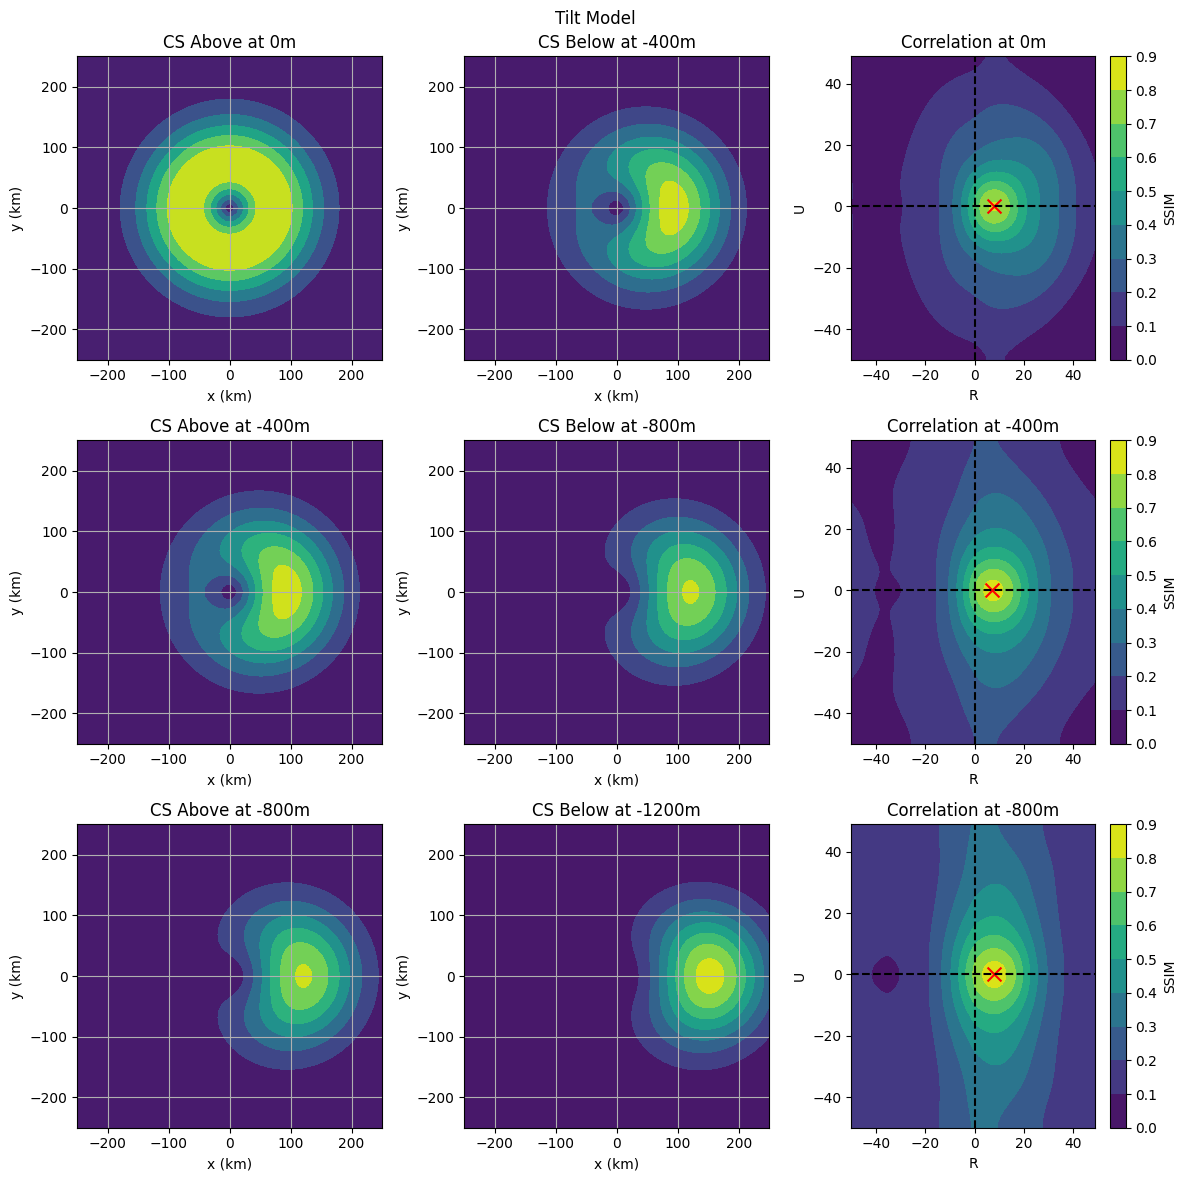

In [8]:
fig, ax = plt.subplots(U_tilt.shape[2]//3, 3, figsize=(12, 12))

img_row = 0
for depth_lvl in range(U_tilt.shape[2]):

    if depth_lvl % 3 == 0 and depth_lvl != len(z_tilt) - 1:
    
        Data_abv = CS_tilt[:, :, depth_lvl].T
        Data_blw = CS_tilt[:, :, depth_lvl + 3].T
        
        df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
        ssim_mat = make_ssim_matrix(df)
        
        # First subplot
        ax[img_row,0].contourf(x_tilt, y_tilt, Data_abv)
        ax[img_row,0].set_title('CS Above at '+str(round(z[depth_lvl]))+'m')
        ax[img_row,0].grid(True)
        ax[img_row,0].set_xlabel('x (km)')
        ax[img_row,0].set_ylabel('y (km)')
        
        # Second subplot
        ax[img_row,1].contourf(x_tilt, y_tilt, Data_blw)
        ax[img_row,1].set_title('CS Below at '+str(round(z[depth_lvl+3]))+'m')
        ax[img_row,1].grid(True)
        ax[img_row,1].set_xlabel('x (km)')
        ax[img_row,1].set_ylabel('y (km)')
        
        # Third subplot
        contour3 = ax[img_row,2].contourf(np.unique(df['Right']), np.unique(df['Up']), ssim_mat.T)
        ax[img_row,2].set_title('Correlation at '+str(round(z[depth_lvl]))+'m')
        ax[img_row,2].scatter(iR, iU, marker='x', color='r', s=100)
        ax[img_row,2].axvline(x=0, color='k', linestyle='--')  
        ax[img_row,2].axhline(y=0, color='k', linestyle='--') 
        ax[img_row,2].set_xlabel('R')
        ax[img_row,2].set_ylabel('U')
        
        cbar = fig.colorbar(contour3, ax=ax[img_row,2])
        cbar.set_label('SSIM')
    
        img_row += 1
    
fig.suptitle('Tilt Model')

plt.tight_layout()
plt.show()

The above image needs to move to the right, to match the below image

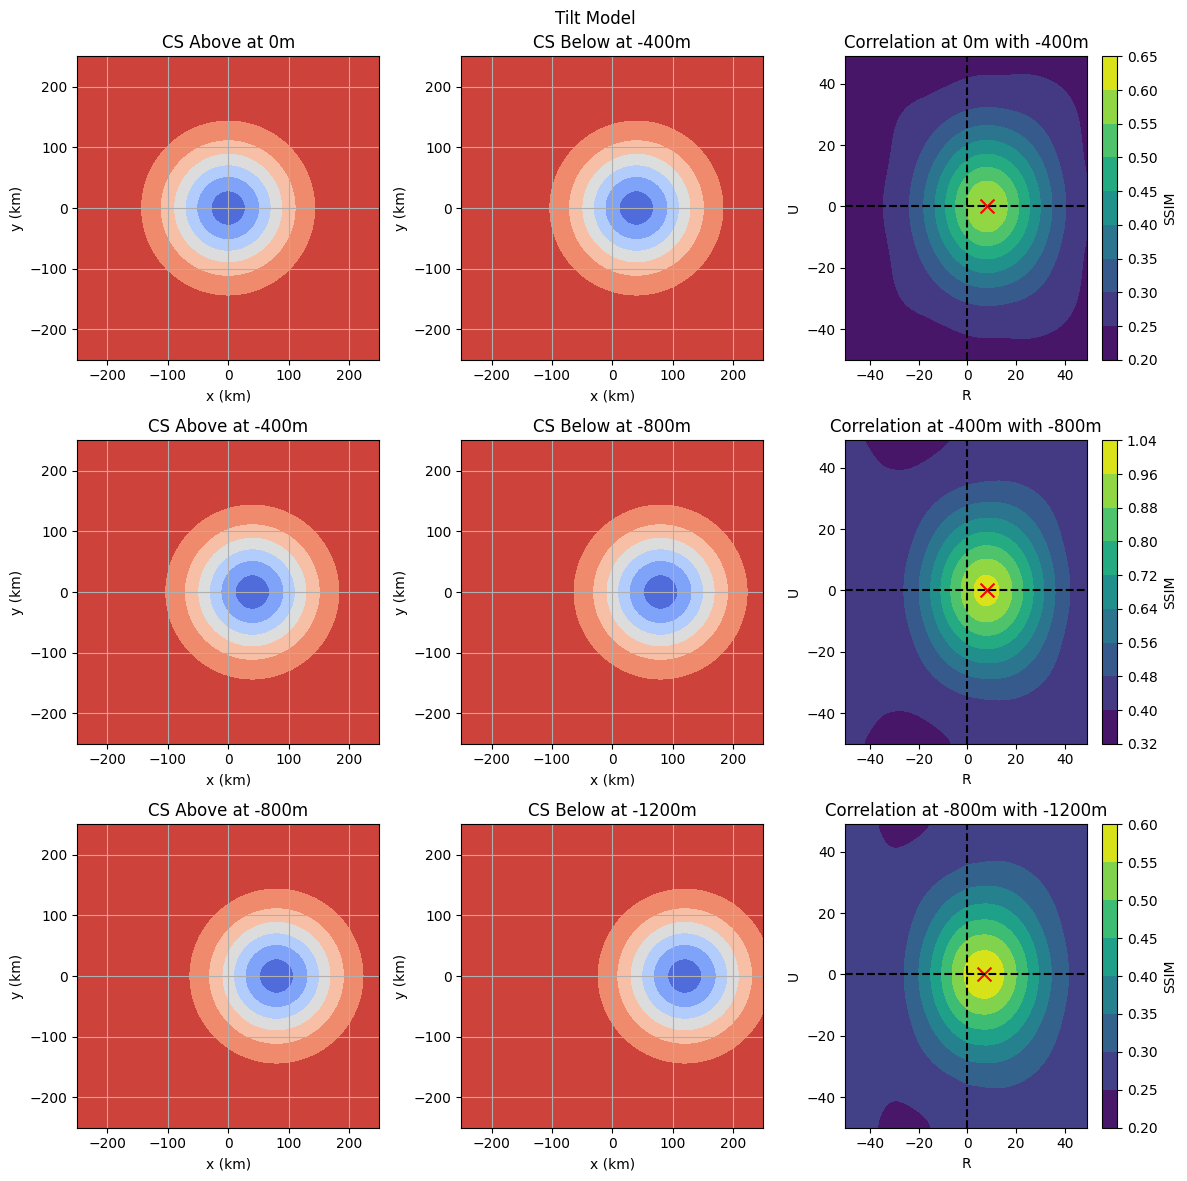

In [9]:
fig, ax = plt.subplots(U_tilt.shape[2]//3, 3, figsize=(12, 12))

img_row = 0
for depth_lvl in range(U_tilt.shape[2]):

    if depth_lvl % 3 == 0 and depth_lvl != len(z_tilt) - 1:
    
        Data_abv = TA_tilt[:, :, depth_lvl].T
        Data_blw = TA_tilt[:, :, depth_lvl + 3].T
        
        df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
        ssim_mat = make_ssim_matrix(df)
        
        # First subplot
        ax[img_row,0].contourf(x_tilt, y_tilt, Data_abv, cmap='coolwarm')
        ax[img_row,0].set_title('CS Above at '+str(round(z[depth_lvl]))+'m')
        ax[img_row,0].grid(True)
        ax[img_row,0].set_xlabel('x (km)')
        ax[img_row,0].set_ylabel('y (km)')
        
        # Second subplot
        ax[img_row,1].contourf(x_tilt, y_tilt, Data_blw, cmap='coolwarm')
        ax[img_row,1].set_title('CS Below at '+str(round(z[depth_lvl+3]))+'m')
        ax[img_row,1].grid(True)
        ax[img_row,1].set_xlabel('x (km)')
        ax[img_row,1].set_ylabel('y (km)')
        
        # Third subplot
        contour3 = ax[img_row,2].contourf(np.unique(df['Right']), np.unique(df['Up']), ssim_mat.T)
        ax[img_row,2].set_title('Correlation at '+str(round(z[depth_lvl]))+'m with '+str(round(z[depth_lvl + 3]))+'m')
        ax[img_row,2].scatter(iR, iU, marker='x', color='r', s=100)
        ax[img_row,2].axvline(x=0, color='k', linestyle='--')  
        ax[img_row,2].axhline(y=0, color='k', linestyle='--') 
        ax[img_row,2].set_xlabel('R')
        ax[img_row,2].set_ylabel('U')
        
        cbar = fig.colorbar(contour3, ax=ax[img_row,2])
        cbar.set_label('SSIM')
    
        img_row += 1
    
fig.suptitle('Tilt Model')

plt.tight_layout()
plt.show()

## Results

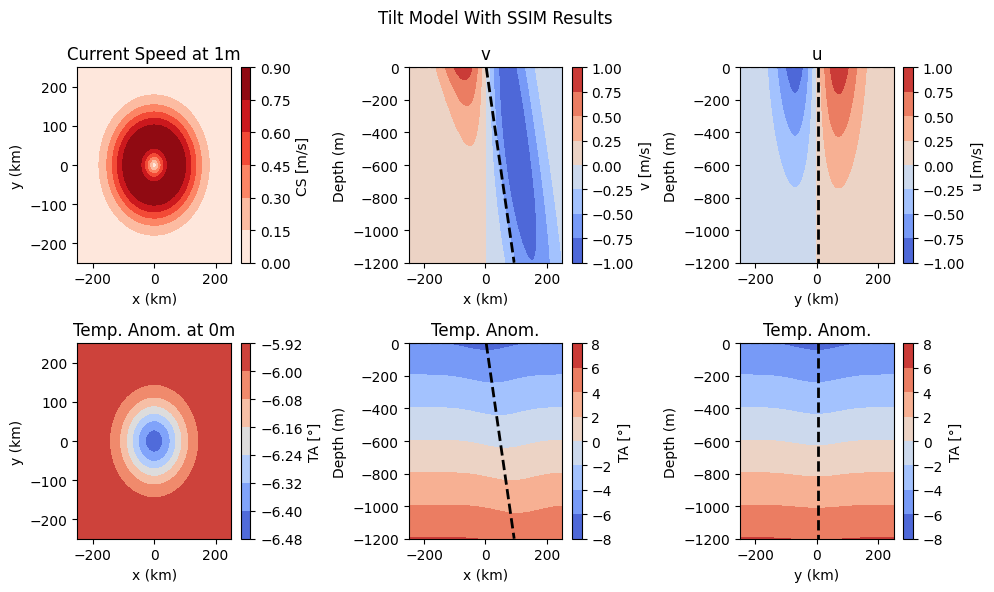

In [68]:
Us, Rs = [0], [0]
for depth_lvl in range(U_tilt.shape[2]-1):
        Data_abv = CS_tilt[:, :, depth_lvl].T
        Data_blw = CS_tilt[:, :, depth_lvl + 1].T
        _, iU, iR = correlation_center_finder(Data_blw, Data_abv)
        Us.append(int(iU)+Us[-1])
        Rs.append(int(iR)+Rs[-1]) 
mx, my = len(x_tilt)//2, len(y_tilt)//2
xc, yc, zc = x_tilt[mx + np.array(Rs)], y_tilt[my + np.array(Us)], z_tilt

DEPTH_LVL = 0
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

# Plot Current Speed
c1 = axs[0,0].contourf(x_tilt, y_tilt, CS_tilt[:,:,DEPTH_LVL].T, cmap='Reds')
fig.colorbar(c1, ax=axs[0,0], label='CS [m/s]')
axs[0,0].set_title('Current Speed at '+str(round(z[DEPTH_LVL]))+'m')
axs[0,0].set_xlabel('x (km)')
axs[0,0].set_ylabel('y (km)')

# Plot v velocity
contour_v = axs[0,1].contourf(y_tilt, z_tilt, V_tilt[:,V_tilt.shape[1]//2,:].T, cmap='coolwarm')
fig.colorbar(contour_v, ax=axs[0,1], label='v [m/s]')
axs[0,1].plot([y_tilt[0],y_tilt[-1]],[z_tilt[DEPTH_LVL],z_tilt[DEPTH_LVL]],'--',color='k')
axs[0,1].plot(xc, zc, '--', linewidth=2, color='k')
axs[0,1].set_title('v')
axs[0,1].set_xlabel('x (km)')
axs[0,1].set_ylabel('Depth (m)')

# Plot u velocity
contour_u = axs[0,2].contourf(x_tilt, z_tilt, U_tilt[U_tilt.shape[0]//2,:,:].T, cmap='coolwarm')
fig.colorbar(contour_u, ax=axs[0,2], label='u [m/s]')
axs[0,2].plot([x_tilt[0],x_tilt[-1]],[z_tilt[DEPTH_LVL],z_tilt[DEPTH_LVL]],'--',color='k')
axs[0,2].plot(yc, zc, '--', linewidth=2, color='k')
axs[0,2].set_title('u')
axs[0,2].set_xlabel('y (km)')
axs[0,2].set_ylabel('Depth (m)')

# Plot Temperature Anomaly (TA) for the current depth level
c2 = axs[1,0].contourf(x_tilt, y_tilt, TA_tilt[:,:,DEPTH_LVL].T, cmap='coolwarm')
fig.colorbar(c2, ax=axs[1,0], label='TA [°]')
axs[1,0].set_title('Temp. Anom. at '+str(round(z_tilt[DEPTH_LVL]))+'m')
axs[1,0].set_xlabel('x (km)')
axs[1,0].set_ylabel('y (km)')

# Plot Temperature Anomaly at y = middle slice
temp_y = axs[1,1].contourf(y_tilt, z_tilt, TA_tilt[:,TA_tilt.shape[1]//2,:].T, cmap='coolwarm')
fig.colorbar(temp_y, ax=axs[1,1], label='TA [°]')
axs[1,1].plot([y_tilt[0],y_tilt[-1]],[z_tilt[DEPTH_LVL],z_tilt[DEPTH_LVL]],'--',color='k')
axs[1,1].plot(xc, zc, '--', linewidth=2, color='k')
axs[1,1].set_title('Temp. Anom.')
axs[1,1].set_xlabel('x (km)')
axs[1,1].set_ylabel('Depth (m)')

# Plot Temperature Anomaly at x = middle slice
temp_x = axs[1,2].contourf(x_tilt, z_tilt, TA_tilt[TA_tilt.shape[0]//2,:,:].T, cmap='coolwarm')
fig.colorbar(temp_x, ax=axs[1,2], label='TA [°]')
axs[1,2].plot([x_tilt[0],x_tilt[-1]],[z_tilt[DEPTH_LVL],z_tilt[DEPTH_LVL]],'--',color='k')
axs[1,2].plot(yc, zc, '--', linewidth=2, color='k')
axs[1,2].set_title('Temp. Anom.')
axs[1,2].set_xlabel('y (km)')
axs[1,2].set_ylabel('Depth (m)')

fig.suptitle('Tilt Model With SSIM Results')

plt.tight_layout()
plt.show()

## MOCA

In [61]:
def polynomial_fit_with_error(x, y, degree=1):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]
    if degree not in [0, 1]:
        raise ValueError("Degree must be 0 or 1.")
    coefficients, cov = np.polyfit(x, y, degree, cov=True)  # coefficients = [slope, intercept]
    y_fit = np.polyval(coefficients, x)
    residuals = y - y_fit
    std_err_coeffs = np.sqrt(np.diag(cov))
    ss_total = np.sum((y - np.mean(y))**2)
    ss_residuals = np.sum(residuals**2)
    r_squared = 1 - (ss_residuals / ss_total)
    return coefficients, std_err_coeffs, r_squared

def haversine_distance(lat1, lon1, bearing, distance):
    R = 6371000
    lat1, lon1, bearing = map(math.radians, [lat1, lon1, bearing])

    lat2 = math.asin(math.sin(lat1) * math.cos(distance / R) +
                     math.cos(lat1) * math.sin(distance / R) * math.cos(bearing))
    lon2 = lon1 + math.atan2(math.sin(bearing) * math.sin(distance / R) * math.cos(lat1),
                             math.cos(distance / R) - math.sin(lat1) * math.sin(lat2))

    return math.degrees(lat2), math.degrees(lon2)

def true_bearing(x, y):
    angle_radians = math.atan2(y, x)
    angle_degrees = math.degrees(angle_radians)
    bearing = (90 - angle_degrees) % 360
    return bearing

def is_pos_def(Q):
    eigenvalues = np.linalg.eigvals(Q)
    return np.all(eigenvalues > 0)

In [63]:
i_left = 40
i_right = 60
j_down = 40
j_up = 60

xx = x_tilt[i_left:i_right]
yy = y_tilt[j_down:j_up]

depth_dics3 = {}
for depth_lvl in range(U_tilt.shape[2]):
    u1 = U_tilt[i_left:i_right, U_tilt.shape[1]//2, depth_lvl]
    v1 = V_tilt[i_left:i_right, V_tilt.shape[1]//2,depth_lvl]
    u2 = U_tilt[U_tilt.shape[0]//2, j_down:j_up, depth_lvl]
    v2 = V_tilt[V_tilt.shape[0]//2, j_down:j_up, depth_lvl]
    As, dAs, r2A = polynomial_fit_with_error(xx, u1, degree=1)
    A1, A0 = As
    Bs, dBs, r2B = polynomial_fit_with_error(xx, v1, degree=1)
    B1, B0 = Bs
    Cs, dCs, r2C = polynomial_fit_with_error(yy, u2, degree=1)
    C1, C0 = Cs
    Ds, DAs, r2D = polynomial_fit_with_error(yy, v2, degree=1)
    D1, D0 = Ds
    alpha = A0 if r2A < r2B else C0
    beta = B0 if r2B < r2D else D0
    gamma = A1 if r2A < r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
    Q = np.array([[q11, q12], [q12, q22]])
    if is_pos_def(Q) or is_pos_def(-Q):
        yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))
        xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))
    else:
        xc = yc = np.nan
    depth_dics3[f'Depth{depth_lvl}'] = {
        'dfx': pd.DataFrame({'x': xx, 'u1': u1, 'v1': v1}),
        'dfy': pd.DataFrame({'y': yy, 'u2': u2, 'v2': v2}),
        'q11': q11, 'q12': q12, 'q22': q22,
        'xc': xc, 'yc': yc, 
        'Depth': z[depth_lvl]
    }

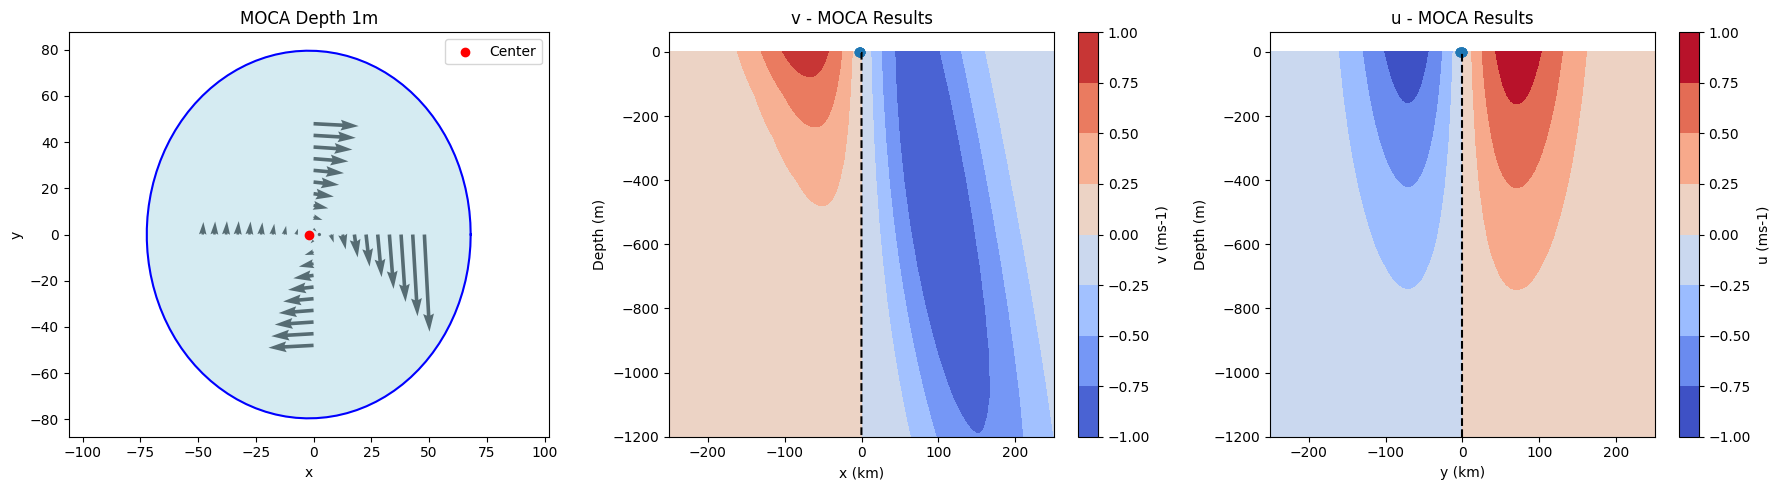

In [67]:
depth_lvl = 'Depth8'

dfx = depth_dics3[depth_lvl]['dfx']
dfy = depth_dics3[depth_lvl]['dfy']
x1, y1 = dfx.x, [0] * len(dfx.x)
x2, y2 = [0] * len(dfy.y), dfy.y
u1, v1 = dfx.u1, dfx.v1
u2, v2 = dfy.u2, dfy.v2

q11, q12, q22 = depth_dics3[depth_lvl]['q11'], depth_dics3[depth_lvl]['q12'], depth_dics3[depth_lvl]['q22']
xc_lvl, yc_lvl = depth_dics3[depth_lvl]['xc'], depth_dics3[depth_lvl]['yc']
depth = depth_dics3[depth_lvl]['Depth']
s = 5.991

Q = np.array([[q11, q12], [q12, q22]])
if not is_pos_def(Q):
    Q = -Q

num_points = 100
theta = np.linspace(0, 2 * np.pi, num_points)
ellipse = np.array([np.cos(theta), np.sin(theta)])
eigvals, eigvecs = np.linalg.eig(Q)
# if np.any(eigvals <= 0):
#     raise ValueError(f"Matrix Q is not positive definite. Eigenvalues: {eigvals}")

axes = np.sqrt(s / eigvals)
ellipse_transformed = eigvecs @ np.diag(axes) @ ellipse
ellipse_transformed += np.array([[xc_lvl], [yc_lvl]])

DISPLAY_WIDTH = 200000

xc_raw, yc_raw, zc = [], [], []
for depth_dic in depth_dics3.values():
    xc_raw.append(depth_dic['xc'])
    yc_raw.append(depth_dic['yc'])
    zc.append(depth_dic['Depth'])
xc, yc = xc_raw, yc_raw

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# First subplot
axs[0].quiver(x1, y1, u1, v1)
axs[0].quiver(x2, y2, u2, v2)
axs[0].fill(ellipse_transformed[0], ellipse_transformed[1], color='lightblue', alpha=0.5)
axs[0].plot(ellipse_transformed[0], ellipse_transformed[1], color='blue')
axs[0].scatter([xc_lvl], [yc_lvl], color='red', zorder=5, label='Center')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend()
axs[0].set_title(f'MOCA Depth {depth:.0f}m')
axs[0].axis('equal')

# Second subplot
v_cross = V_tilt[:, V_tilt.shape[1]//2, :]
v_data_range = np.nanmax(np.abs(v_cross))
X, Z = np.meshgrid(x_tilt, z_tilt)
c1 = axs[1].contourf(X, Z, v_cross.T, cmap='coolwarm', vmin=-v_data_range, vmax=v_data_range)
c1_contour = axs[1].contour(X, Z, v_cross.T, levels=[0], colors='black', linestyles='--')
axs[1].set_xlabel('x (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title('v - MOCA Results')
axs[1].plot(xc, zc, '-', linewidth=1.5)
axs[1].scatter(xc, zc)
fig.colorbar(c1, ax=axs[1], label='v (ms-1)')

# Third subplot
u_cross = U_tilt[U_tilt.shape[0]//2, :, :]
u_data_range = np.nanmax(np.abs(u_cross))
Y, Z = np.meshgrid(y_tilt, z_tilt)
c2 = axs[2].contourf(Y, Z, u_cross.T, cmap='coolwarm', vmin=-u_data_range, vmax=u_data_range)
c2_contour = axs[2].contour(Y, Z, u_cross.T, levels=[0], colors='black', linestyles='--')
axs[2].set_xlabel('y (km)')
axs[2].set_ylabel('Depth (m)')
axs[2].set_title('u - MOCA Results')
axs[2].plot(yc, zc, '-', linewidth=1.5)
axs[2].scatter(yc, zc)
fig.colorbar(c2, ax=axs[2], label='u (ms-1)')

plt.tight_layout()
plt.show()

## 3D SSIM Isosurface
Problem!:

Looks the same for non-tilt and tilt

SSIM is calcualted between neighbouring layers, differences are hence relatively small and do not show as tilt

In [10]:
ssim_cube = np.zeros_like(TA)
for depth_lvl in range(TA.shape[2]-1):
    Data_abv = TA[:, :, depth_lvl].T
    Data_blw = TA[:, :, depth_lvl + 1].T
    df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
    ssim_cube[:,:,depth_lvl] = make_ssim_matrix(df)

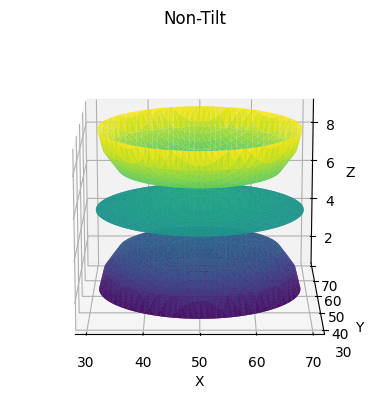

In [11]:
from skimage import measure

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

# Generate the isosurface
verts, faces, _, _ = measure.marching_cubes(np.flip(ssim_cube, axis=2), .7)

# Plot the isosurface
ax1.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces,
                 cmap='viridis', lw=1)

# Set labels and title
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Non-Tilt')
ax1.view_init(elev=15, azim=270)

plt.show()


In [12]:
ssim_cube_tilt = np.zeros_like(TA_tilt)
for depth_lvl in range(TA_tilt.shape[2]-1):
    Data_abv = TA_tilt[:, :, depth_lvl].T
    Data_blw = TA_tilt[:, :, depth_lvl + 1].T
    df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
    ssim_cube_tilt[:,:,depth_lvl] = make_ssim_matrix(df)

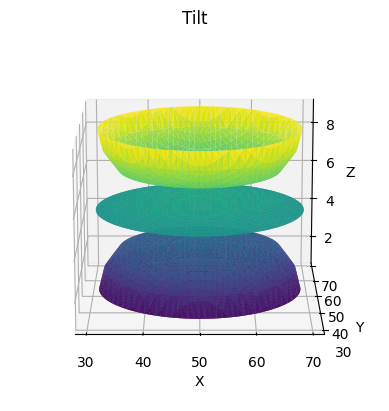

In [13]:
from skimage import measure

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

# Generate the isosurface
verts, faces, _, _ = measure.marching_cubes(np.flip(ssim_cube, axis=2), .7)

# Plot the isosurface
ax1.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces,
                 cmap='viridis', lw=1)

# Set labels and title
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Tilt')
ax1.view_init(elev=15, azim=270)

plt.show()



In [14]:
ssim_cube_CS = np.zeros_like(CS)
for depth_lvl in range(CS.shape[2]-1):
    Data_abv = CS[:, :, depth_lvl].T
    Data_blw = CS[:, :, depth_lvl + 1].T
    df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
    ssim_cube_CS[:,:,depth_lvl] = make_ssim_matrix(df)

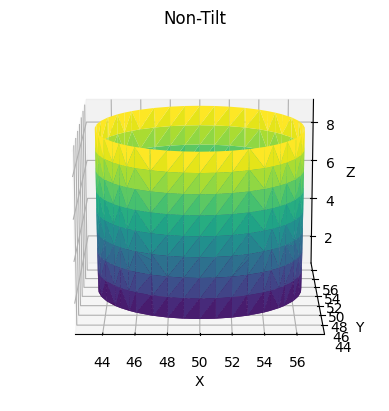

In [15]:
from skimage import measure

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

# Generate the isosurface
verts, faces, _, _ = measure.marching_cubes(np.flip(ssim_cube_CS, axis=2), .7)

# Plot the isosurface
ax1.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces,
                 cmap='viridis', lw=1)

# Set labels and title
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Non-Tilt')
ax1.view_init(elev=15, azim=270)

plt.show()

In [16]:
ssim_cube_tilt_CS = np.zeros_like(CS_tilt)
for depth_lvl in range(CS_tilt.shape[2]-1):
    Data_abv = CS_tilt[:, :, depth_lvl].T
    Data_blw = CS_tilt[:, :, depth_lvl + 1].T
    df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
    ssim_cube_tilt_CS[:,:,depth_lvl] = make_ssim_matrix(df)

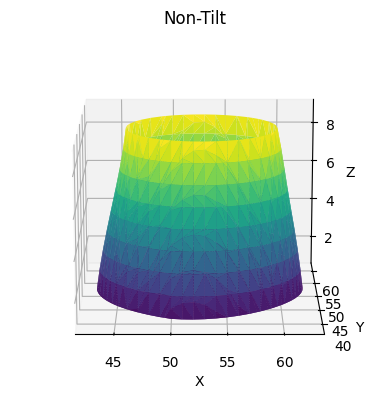

In [17]:
from skimage import measure

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

# Generate the isosurface
verts, faces, _, _ = measure.marching_cubes(np.flip(ssim_cube_tilt_CS, axis=2), .7)

# Plot the isosurface
ax1.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces,
                 cmap='viridis', lw=1)

# Set labels and title
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Non-Tilt')
ax1.view_init(elev=15, azim=270)

plt.show()